### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [12]:
%pip install --quiet -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load .env file (Copy .env-sample to .env and update accordingly)

In [13]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv() # take environment variables from .env.

# Variables not used here do not need to be updated in your .env file
search_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_embedding_deployment_id = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT_ID"]
recursivetextsplitter_searchindex = os.environ["AZURE_SEARCH_LANGCHAIN_RECURSIVETEXTSPLITTER_INDEX"]

search_credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
azure_openai_key = os.environ["AZURE_OPENAI_KEY"] if len(os.environ["AZURE_OPENAI_KEY"]) > 0 else None

### Setup sample resources for embedding chunks

In [14]:
from openai import AzureOpenAI
from azure.identity import get_bearer_token_provider

azure_openai_client = None
if azure_openai_key:
    azure_openai_client = AzureOpenAI(
        api_key=azure_openai_key, 
        api_version="2023-05-15",
        azure_deployment=azure_openai_embedding_deployment_id,
        azure_endpoint=azure_openai_endpoint)
else:
    azure_openai_client = AzureOpenAI(
        azure_ad_token_provider=get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
        api_version="2023-05-15",
        azure_deployment=azure_openai_embedding_deployment_id,
        azure_endpoint=azure_openai_endpoint)

### Setup sample resources for recursive text splitter chunking

In [25]:
from azure.search.documents.indexes import SearchIndexClient
from lib.common import (
    create_search_index,
)

search_index_client = SearchIndexClient(endpoint=search_endpoint, credential=search_credential)
rts_searchindex = create_search_index(
    recursivetextsplitter_searchindex,
    azure_openai_endpoint,
    azure_openai_embedding_deployment_id,
    azure_openai_key
)
search_index_client.create_or_update_index(rts_searchindex)

print("Created recursive text splitter index")


Created recursive text splitter index


### Load PDF

In [16]:
from langchain_community.document_loaders import PyPDFLoader
import os

loader = PyPDFLoader(os.path.join("data", "earth_at_night_508.pdf"))
pages = loader.load()


### Generate histogram of token and character lengths per page

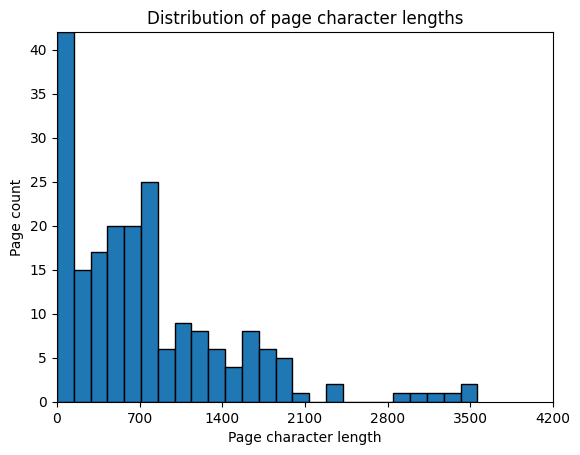

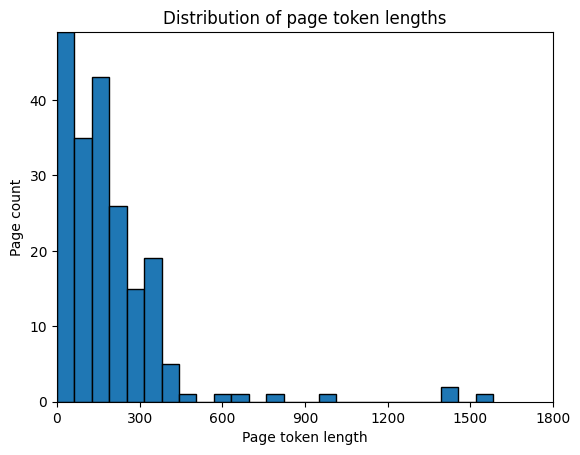

In [17]:
%matplotlib inline
from lib.common import plot_chunk_histogram, get_token_length

page_content = [page.page_content for page in pages]

plot_chunk_histogram(
    chunks=page_content,
    length_fn=len,
    title="Distribution of page character lengths",
    xlabel="Page character length",
    ylabel="Page count")
plot_chunk_histogram(
    chunks=page_content,
    length_fn=get_token_length,
    title="Distribution of page token lengths",
    xlabel="Page token length",
    ylabel="Page count")



### Chunk PDF using Recursive text splitter

We use the output of the above historgrams to guide us into selecting a 600 token chunk length with a 150 token overlap.

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from lib.common import get_encoding_name

# from_tiktoken_encoder enables use to split on tokens rather than characters
recursive_text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
   encoding_name=get_encoding_name(),
   chunk_size=600, 
   chunk_overlap=125
)

recursive_text_splitter_chunks = recursive_text_splitter.split_documents(pages)

### Generate histogram of chunk character and token lengths

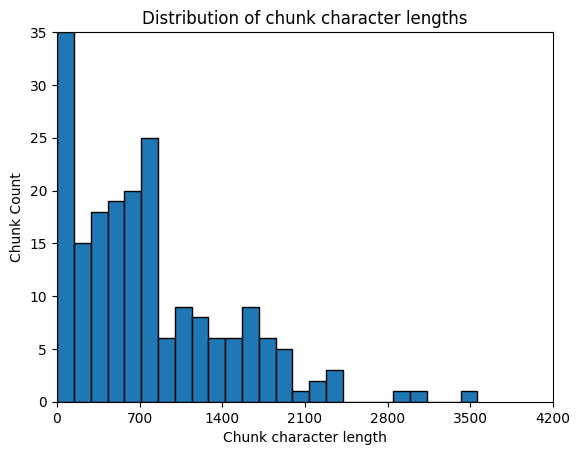

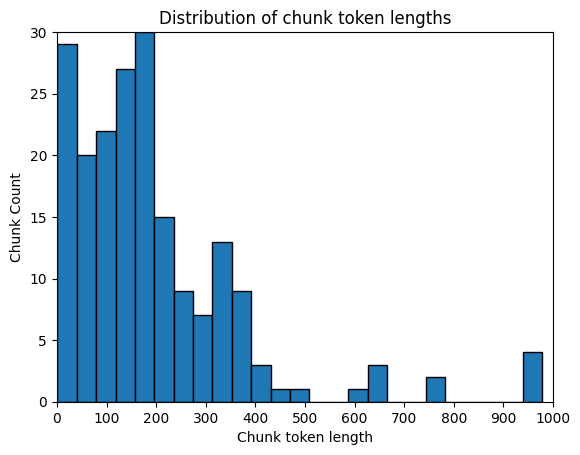

In [23]:
chunk_content = [chunk.page_content for chunk in recursive_text_splitter_chunks]

plot_chunk_histogram(
    chunks=chunk_content,
    length_fn=len,
    title="Distribution of chunk character lengths",
    xlabel="Chunk character length")
plot_chunk_histogram(
    chunks=chunk_content,
    length_fn=get_token_length,
    title="Distribution of chunk token lengths",
    xlabel="Chunk token length")

### Embed Recursive text splitter chunks

In [24]:
recursive_text_splitter_embeddings = azure_openai_client.embeddings.create(input=chunk_content, model=azure_openai_embedding_deployment_id)
recursive_text_splitter_embeddings = [result.embedding for result in recursive_text_splitter_embeddings.data]

### Upload chunks to search index

In [26]:
recursive_search_client = search_index_client.get_search_client(recursivetextsplitter_searchindex)

docs = [
    {
        "parent_id": "0",
        "chunk_id": f"earth-at-night-508-pdf_0_0_{i}",
        "chunk": chunk.page_content,
        "title": "earth_at_night_508.pdf",
        "vector": recursive_text_splitter_embeddings[i]
    }
    for i, chunk in enumerate(recursive_text_splitter_chunks)
]

recursive_search_client.upload_documents(docs)

print("Uploaded chunks and embeddings for recursive text splitter")

Uploaded chunks and embeddings for recursive text splitter
